# Imports

In [1]:
#%matplotlib widget
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from math import sqrt, erf, exp
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR
from sklearn import metrics as me
from catboost import CatBoostRegressor
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from sklearn import preprocessing

from tqdm import tqdm
from scipy import stats
from scipy.special import erfinv
from sklearn.neighbors import KernelDensity

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel as W

pd.set_option('display.max_columns', None)

from sklearn.neighbors import KernelDensity
from crepes_weighted import ConformalPredictiveSystem, WrapRegressor  # type: ignore
from crepes_weighted.extras import DifficultyEstimator, binning  # type: ignore
import warnings


import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from WCDRF.base import *
from WCDRF.synthetic_data_generation import *

# Synthetic Use Case

In [33]:
EXPERIMENT_SOURCE = 2
EXPERIMENT_SCENARIO = 1
INTERVENTIONAL_BOOL = False

synthetic_generator = synthetic_data_generator(source = EXPERIMENT_SOURCE, scenario = EXPERIMENT_SCENARIO)
synthetic_DRF_df = synthetic_generator.generate_synthetic_DRF_data(N = 5000)

OraclePropensityWrapperObject = OraclePropensityWrapper(synthetic_generator)

features = list(synthetic_DRF_df.columns.values[:-2])
treatment = "W"
outcome = "Y"

In [34]:
synthetic_DRF_df_train_large, synthetic_DRF_df_test = train_test_split(synthetic_DRF_df,test_size=0.25)
synthetic_DRF_df_train, synthetic_DRF_df_calibrate = train_test_split(synthetic_DRF_df_train_large,test_size=0.33)

# only useful for experiment setup 1
# if INTERVENTIONAL_BOOL and EXPERIMENT_SOURCE == 1:
#     interventional_synthetic_generator = synthetic_data_generator(source = EXPERIMENT_SOURCE, scenario = EXPERIMENT_SCENARIO, interventional_mode="HARD", interventional_delta=5)
#     synthetic_DRF_df_test = synthetic_generator.generate_synthetic_DRF_data(N = 1000)

### CADRF

In [36]:
# CATBOOST
CATBOOST_propensity_model = CatBoostRegressor(verbose=False,iterations=4000,use_best_model=True)
C_DRF_CATBOOST_base = CatBoostRegressor(verbose=False,iterations=5000,use_best_model=True)

CPS_C_DRF_CATBOOST_base = DRFWrapRegressor(CATBOOST_propensity_model, C_DRF_CATBOOST_base,adaptive=True)
CPS_C_DRF_CATBOOST_base.fit(synthetic_DRF_df_train[features+[treatment]], synthetic_DRF_df_train[outcome].values,eval_set=(synthetic_DRF_df_calibrate[features+[treatment]],synthetic_DRF_df_calibrate[outcome]))

CPS_C_DRF_CATBOOST_base.fit_propensity(synthetic_DRF_df_train[features], synthetic_DRF_df_train[treatment].values,eval_set=(synthetic_DRF_df_calibrate[features],synthetic_DRF_df_calibrate[treatment]))
CPS_C_DRF_CATBOOST_base.calibrate_propensity(synthetic_DRF_df_calibrate[features], synthetic_DRF_df_calibrate[treatment].values)

# This code is for when you need to use the oracle wrapper instead
# CPS_C_DRF_CATBOOST_base = DRFWrapRegressor(OraclePropensityWrapperObject, C_DRF_CATBOOST_base,adaptive=True, oracle_propensity=True)
# CPS_C_DRF_CATBOOST_base.fit(synthetic_DRF_df_train[features+[treatment]], synthetic_DRF_df_train[outcome].values,eval_set=(synthetic_DRF_df_calibrate[features+[treatment]],synthetic_DRF_df_calibrate[outcome]))


In [53]:
use_oracles = False
use_method = "CATBOOST" 

Coverages_df = pd.DataFrame(columns=["method","treatment","effective_sample_rate","confidence","emp_coverage"])
cov_range = np.array([0.05, 0.33, 0.5, 0.7, 0.8, 0.9, 0.95]) 

cal_df = synthetic_DRF_df_calibrate.copy(deep=True)
test_df = synthetic_DRF_df_test.copy(deep=True)

plot_W_min = synthetic_DRF_df_train["W"].quantile(0.02)
plot_W_max = synthetic_DRF_df_train["W"].quantile(0.98)

treatment_range = np.arange(plot_W_min,plot_W_max,(plot_W_max-plot_W_min)/40.0)

P_d_marginal_mean = cal_df[treatment].mean()
P_d_marginal_std = cal_df[treatment].std()
P_d_distribution = norm(P_d_marginal_mean,P_d_marginal_std)
y_min_calibration = cal_df[outcome].min()
y_max_calibration = cal_df[outcome].max()


if use_oracles:
    cal_df["P_D_di_propensity_pdf"] = np.array([synthetic_generator.get_treatment_mean(row[features].values).pdf(row[treatment]) for idx,row in cal_df.iterrows() ])
    cal_df["Lengthscale"] = np.array([2 *((0.3*synthetic_generator.get_treatment_std(row[features].values)) ** 2)  for idx,row in cal_df.iterrows() ])

else:
    CPS_C_DRF_CATBOOST_base.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
    CPS_C_DRF_CATBOOST_base.fit_difficulty_estimator(synthetic_DRF_df_train[features].values, synthetic_DRF_df_train[treatment].values, synthetic_DRF_df_train[outcome].values)


CATBOOST_bounds_cov_dict = {}

for d_t in tqdm(treatment_range):
    int_coverage_df_calibrate = test_df[features+[treatment]].copy(deep=True)
    int_coverage_df_calibrate[treatment]=d_t

    if use_oracles:
        target_propensities =  np.array([synthetic_generator.get_treatment_mean(row[features]).pdf(d_t) for idx,row in int_coverage_df_calibrate.iterrows()])

    CPS_C_DRF_CATBOOST_base.calibrate(
        cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, 
        target_treatment=d_t, cps=False, use_propensity = False,local_conditional_mode = True
        )
    effective_sample_rate = CPS_C_DRF_CATBOOST_base.effective_sample_rate
    local_CATBOOST_bounds_cov_dict = {}


    true_observation_mean = synthetic_generator.extract_CDRF(test_df[features].values,np.array([d_t])) 
    if len(np.shape(true_observation_mean)) > 1:
        true_observation_mean = true_observation_mean[:,0]

    true_observation_noise = np.random.normal(0,synthetic_generator.Y_std,len(test_df)) 

    if np.shape(true_observation_mean) == np.shape(true_observation_noise):
        true_observation = true_observation_mean + true_observation_noise
    else:
        raise Exception("True observation shape error")


    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        CATBOOST_bounds_matrix = CPS_C_DRF_CATBOOST_base.predict_multi_int(
                            X=int_coverage_df_calibrate[features+[treatment]].values,
                            y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                            y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                            confidence_range=cov_range
                            )
    
    
    for cov, cov_idx in zip(cov_range,range(len(cov_range))):

        CATBOOST_bounds = CATBOOST_bounds_matrix[cov_idx, :, :]
        local_CATBOOST_bounds_cov_dict[cov] = CATBOOST_bounds
        coverage_CATBOOST_emp = np.mean(((true_observation >= CATBOOST_bounds[:,0]) * (true_observation <= CATBOOST_bounds[:,1])))
        Coverages_df = pd.concat([pd.DataFrame([np.array(["CATBOOST",d_t,effective_sample_rate,cov,coverage_CATBOOST_emp])],columns=["method","treatment","effective_sample_rate","confidence","emp_coverage"]),Coverages_df])


    CATBOOST_bounds_cov_dict[d_t] = local_CATBOOST_bounds_cov_dict



100%|██████████| 40/40 [00:23<00:00,  1.72it/s]


In [54]:
Coverages_df["treatment"] = Coverages_df["treatment"].values.astype(np.float64)
Coverages_df["emp_coverage"] = Coverages_df["emp_coverage"].values.astype(np.float64)
Coverages_df["confidence"] = Coverages_df["confidence"].values.astype(np.float64)
Coverages_df["effective_sample_rate"] = Coverages_df["effective_sample_rate"].values.astype(np.float64)

In [63]:
Coverages_df[(Coverages_df.method==use_method)][["confidence","emp_coverage"]].groupby("confidence").mean().sort_values("confidence",ascending=True)["emp_coverage"].values.astype(np.float64)

array([0.03366, 0.19798, 0.31498, 0.44074, 0.50946, 0.622  , 0.70494])

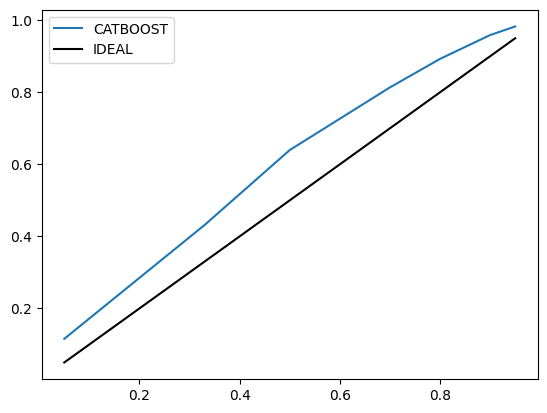

In [20]:
plt.plot(cov_range,Coverages_df[(Coverages_df.method==use_method)][["confidence","emp_coverage"]].groupby("confidence").mean().sort_values("confidence",ascending=True)["emp_coverage"].values.astype(np.float64),label=use_method)
plt.plot(cov_range,cov_range,label="IDEAL",color="black")
plt.legend()

C1    5.946148
C2    2.336670
C3    2.827815
Name: 1906, dtype: float64
738


[]

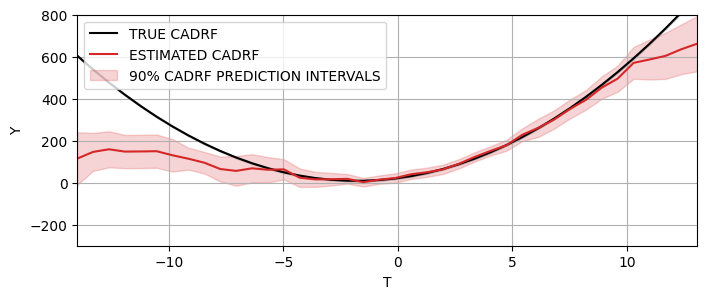

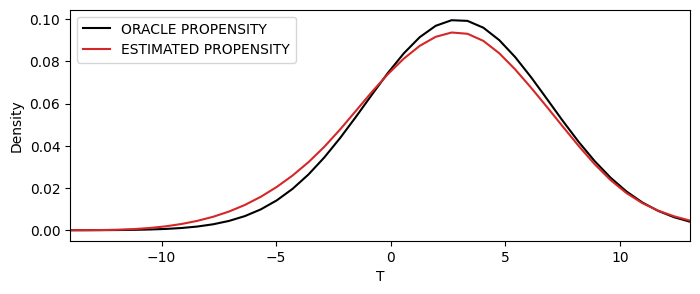

In [54]:
from scipy.special import erfinv

fig, ax = plt.subplots(1,1,figsize=(8,3))

chosen_idx =  738 
chosen_features = test_df.iloc[chosen_idx][features]

print(chosen_features)
print(chosen_idx)
conditional_DRF_dataset = pd.DataFrame(
    np.hstack([np.tile(chosen_features,(len(treatment_range),1)),treatment_range.reshape(-1,1)]),
    columns=features+[treatment]
)

chosen_features = test_df.iloc[chosen_idx][features]

wanted_cov = 0.90

CATBOOST_lower_bounds_cov_list = []
CATBOOST_upper_bounds_cov_list = []

for selected_treatment in treatment_range:
    CATBOOST_lower_bounds_cov_list.append(CATBOOST_bounds_cov_dict[selected_treatment][wanted_cov][chosen_idx,0])
    CATBOOST_upper_bounds_cov_list.append(CATBOOST_bounds_cov_dict[selected_treatment][wanted_cov][chosen_idx,1])

    
if EXPERIMENT_SOURCE == 1:
    ax.plot(treatment_range, synthetic_generator.extract_CDRF(np.array([chosen_features.values]),treatment_range)[0,:] ,label="TRUE CADRF", color="black")
    ax.fill_between(
        treatment_range,
        synthetic_generator.extract_CDRF(np.array([chosen_features.values]),treatment_range)[0,:]-synthetic_generator.Y_std*erfinv(wanted_cov)*sqrt(2),
        synthetic_generator.extract_CDRF(np.array([chosen_features.values]),treatment_range)[0,:]+synthetic_generator.Y_std*erfinv(wanted_cov)*sqrt(2),
        alpha=0.2,color="black")
else:
    ax.plot(treatment_range, synthetic_generator.extract_CDRF(np.array([chosen_features.values]),treatment_range) ,label="TRUE CADRF", color="black")
    ax.fill_between(
        treatment_range,
        synthetic_generator.extract_CDRF(np.array([chosen_features.values]),treatment_range)-synthetic_generator.Y_std*erfinv(wanted_cov)*sqrt(2),
        synthetic_generator.extract_CDRF(np.array([chosen_features.values]),treatment_range)+synthetic_generator.Y_std*erfinv(wanted_cov)*sqrt(2),
        alpha=0.2,color="black")


ax.plot(treatment_range, C_DRF_CATBOOST_base.predict(conditional_DRF_dataset),label="ESTIMATED CADRF",color="C3")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax.fill_between(
        treatment_range,
        np.array(CATBOOST_lower_bounds_cov_list),
        np.array(CATBOOST_upper_bounds_cov_list),label="90% CADRF PREDICTION INTERVALS",
    alpha=0.2,color="C3")


ax.set_ylim(-300,800)
ax.set_xlim([treatment_range[0],treatment_range[-1]])
ax.set_xlabel("T")
ax.set_ylabel("Y")
ax.legend(loc="upper left")
plt.grid()
plt.plot()
# plt.savefig("figures/standard_CP_example.pdf",bbox_inches="tight")
# plt.savefig("figures/global_propensity_example.pdf",bbox_inches="tight")
# plt.savefig("figures/local_example.pdf",bbox_inches="tight")
# plt.savefig("figures/local_propensity_example.pdf",bbox_inches="tight")

plt.figure(figsize=(8,3))
plt.plot(treatment_range,synthetic_generator.get_treatment_mean(np.array([chosen_features.values])).pdf(treatment_range.reshape(-1,1)),label="ORACLE PROPENSITY", color="black")
plt.plot(treatment_range,np.exp(KernelDensity(kernel="gaussian", bandwidth=1.5).fit((CPS_C_DRF_CATBOOST_base.propensityLearner.predict_cps(np.array([chosen_features.values]), return_cpds=True)[0, :, 0]).reshape(-1, 1)).score_samples(treatment_range.reshape(-1,1))),label="ESTIMATED PROPENSITY",color="C3")
plt.legend(loc="upper left")
plt.xlim([treatment_range[0],treatment_range[-1]])
plt.xlabel("T")
plt.ylabel("Density")
plt.plot()
# plt.savefig("figures/treatment_assignment_distribution_example.pdf",bbox_inches="tight")


### Evaluation on observed outcome instead of interventional dataset

In [ ]:
Coverages_df = pd.DataFrame(columns=["method","treatment","confidence","emp_coverage","sharpness"])
cov_range = np.array([0.1,0.3,0.5,0.7,0.8,0.9,0.95,0.99])


cal_df = synthetic_DRF_df_calibrate.copy(deep=True)

test_df = synthetic_DRF_df_test.copy(deep=True)

plot_W_min = synthetic_DRF_df_train["W"].min()
plot_W_max = synthetic_DRF_df_train["W"].max()

y_min_calibration = cal_df[outcome].min()
y_max_calibration = cal_df[outcome].max()

CPS_C_DRF_CATBOOST_base.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
CPS_C_DRF_CATBOOST_base.fit_difficulty_estimator(synthetic_DRF_df_train[features].values, synthetic_DRF_df_train[treatment].values, synthetic_DRF_df_train[outcome].values)

i = 0
for _,sample in test_df.iterrows():
    print(f"\r {i}/{len(test_df)}",end="")
    d_t = sample[treatment]

    CPS_C_DRF_CATBOOST_base.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, target_treatment=d_t, cps=False, use_propensity = True)#, cps=True)


    true_observation = sample[outcome]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        CATBOOST_bounds_matrix = CPS_C_DRF_CATBOOST_base.predict_multi_int(
                            X=pd.DataFrame(sample[features+[treatment]].values.reshape(1,-1),columns=features+[treatment]),
                            y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                            y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                            confidence_range=cov_range
                            )

    for cov, cov_idx in zip(cov_range,range(len(cov_range))):

        CATBOOST_bounds = CATBOOST_bounds_matrix[cov_idx, :, :]
        coverage_CATBOOST_emp = np.mean(((true_observation >= CATBOOST_bounds[:,0]) * (true_observation <= CATBOOST_bounds[:,1])))

        sharpness_CATBOOST_emp = np.mean(CATBOOST_bounds[:,1] - CATBOOST_bounds[:,0])

        Coverages_df = pd.concat([pd.DataFrame([np.array(["CATBOOST",d_t,cov,coverage_CATBOOST_emp, sharpness_CATBOOST_emp])],columns=["method","treatment","confidence","emp_coverage","sharpness"]),Coverages_df])

    i += 1


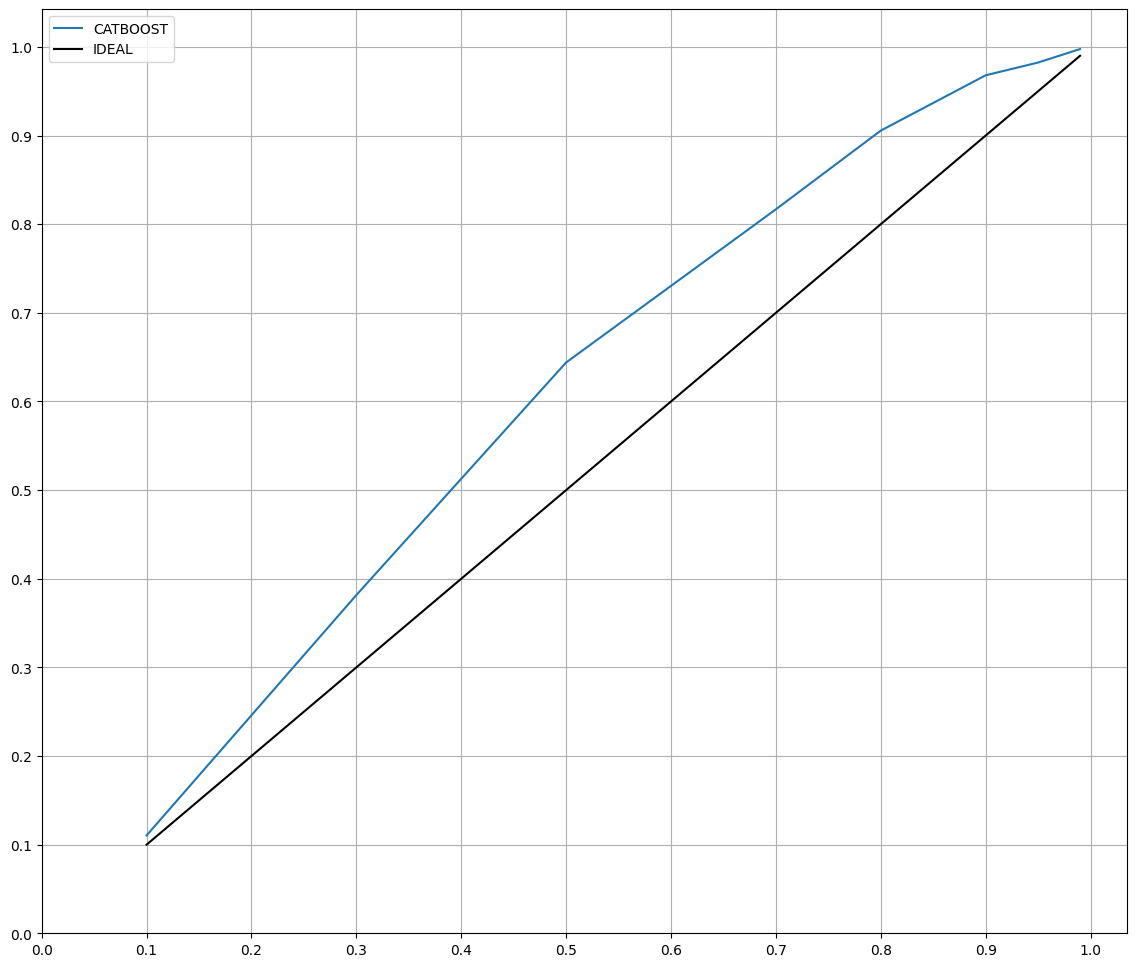

In [177]:
plt.figure(figsize=(10,8))
plt.plot(cov_range,Coverages_df[(Coverages_df.method=="CATBOOST")][["confidence","emp_coverage"]].groupby("confidence").mean().sort_values("confidence",ascending=True)["emp_coverage"].values.astype(np.float64),label="CATBOOST")
plt.plot(cov_range,cov_range,label="IDEAL",color="black")
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()
plt.grid()

# EXPERIMENT LOOP SYNTHETIC

In [ ]:
import copy

### SETTINGS
for EXPERIMENT_SOURCE, EXPERIMENT_SCENARIO in zip([0,0,0,0,0,0,0],[2,3,4,5,6,7,8]):
    print(f"SOURCE = {EXPERIMENT_SOURCE} | Scenario number = {EXPERIMENT_SCENARIO}")
    INTERVENTIONAL_BOOL = False
    cps_setting = False
    repeats = 50
    cov_range = np.array([0.05, 0.33, 0.5, 0.7, 0.8, 0.9, 0.95]) 

    repeat_final_dict_local_prop = {}
    repeat_final_dict_global_prop = {}
    repeat_final_dict_local_NO_prop = {}
    repeat_final_dict_global_NO_prop = {}
    repeat_dict_GP = {}
    repeat_dict_catboost_RMSE_Uncertainty = {}

    repeat_final_dict_adaptive_local_prop = {}
    repeat_final_dict_adaptive_global_prop = {}
    
    repeat_final_dict_oracle_local_prop = {}
    repeat_final_dict_oracle_global_prop = {}
    repeat_final_dict_oracle_adaptive_local_prop = {}
    repeat_final_dict_oracle_adaptive_global_prop = {}

    treatment_range = np.array([])

    for repeat_numb in tqdm(range(repeats)):

        synthetic_generator = synthetic_data_generator(source = EXPERIMENT_SOURCE, scenario = EXPERIMENT_SCENARIO) 
        synthetic_DRF_df = synthetic_generator.generate_synthetic_DRF_data(N = 5000)

        OraclePropensityWrapperObject = OraclePropensityWrapper(synthetic_generator)

        features = list(synthetic_DRF_df.columns.values[:-2])
        treatment = "W"
        outcome = "Y"

        synthetic_DRF_df_train_large, synthetic_DRF_df_test = train_test_split(synthetic_DRF_df,test_size=0.25)
        synthetic_DRF_df_train, synthetic_DRF_df_calibrate = train_test_split(synthetic_DRF_df_train_large,test_size=0.33)

        # GP fit model
        gpr = GaussianProcessRegressor(kernel=RBF()+W(),normalize_y=True)
        gpr.fit(synthetic_DRF_df_train[features+[treatment]], synthetic_DRF_df_train[outcome].values)

        # CATBOOST RMSE UNCERTAINTY
        RMSE_UNCERT_CATBOOST_model = CatBoostRegressor(verbose=False,iterations=4000,use_best_model=True,loss_function="RMSEWithUncertainty")
        RMSE_UNCERT_CATBOOST_model.fit(synthetic_DRF_df_train[features+[treatment]], synthetic_DRF_df_train[outcome].values,eval_set=(synthetic_DRF_df_calibrate[features+[treatment]],synthetic_DRF_df_calibrate[outcome]))
        
        # CATBOOST base models
        CATBOOST_propensity_model = CatBoostRegressor(verbose=False,iterations=4000,use_best_model=True)
        C_DRF_CATBOOST_base = CatBoostRegressor(verbose=False,iterations=5000,use_best_model=True)

        #standard 
        CPS_C_DRF_CATBOOST_base = DRFWrapRegressor(CATBOOST_propensity_model, C_DRF_CATBOOST_base)
        CPS_C_DRF_CATBOOST_base.fit(synthetic_DRF_df_train[features+[treatment]], synthetic_DRF_df_train[outcome].values,eval_set=(synthetic_DRF_df_calibrate[features+[treatment]],synthetic_DRF_df_calibrate[outcome]))

        CPS_C_DRF_CATBOOST_base.fit_propensity(synthetic_DRF_df_train[features], synthetic_DRF_df_train[treatment].values,eval_set=(synthetic_DRF_df_calibrate[features],synthetic_DRF_df_calibrate[treatment]))
        CPS_C_DRF_CATBOOST_base.calibrate_propensity(synthetic_DRF_df_calibrate[features], synthetic_DRF_df_calibrate[treatment].values)

        #standard adaptive
        CPS_C_DRF_CATBOOST_base_adaptive = DRFWrapRegressor(CatBoostRegressor(verbose=False,iterations=4000,use_best_model=True), CatBoostRegressor(verbose=False,iterations=5000,use_best_model=True), adaptive=True)
        CPS_C_DRF_CATBOOST_base_adaptive.fit(synthetic_DRF_df_train[features+[treatment]], synthetic_DRF_df_train[outcome].values,eval_set=(synthetic_DRF_df_calibrate[features+[treatment]],synthetic_DRF_df_calibrate[outcome]))

        CPS_C_DRF_CATBOOST_base_adaptive.fit_propensity(synthetic_DRF_df_train[features], synthetic_DRF_df_train[treatment].values,eval_set=(synthetic_DRF_df_calibrate[features],synthetic_DRF_df_calibrate[treatment]))
        CPS_C_DRF_CATBOOST_base_adaptive.calibrate_propensity(synthetic_DRF_df_calibrate[features], synthetic_DRF_df_calibrate[treatment].values)

        #oracle standard
        CPS_C_DRF_CATBOOST_ORACLE = DRFWrapRegressor(OraclePropensityWrapperObject, CatBoostRegressor(verbose=False,iterations=4000,use_best_model=True), oracle_propensity=True)
        CPS_C_DRF_CATBOOST_ORACLE.fit(synthetic_DRF_df_train[features+[treatment]], synthetic_DRF_df_train[outcome].values,eval_set=(synthetic_DRF_df_calibrate[features+[treatment]],synthetic_DRF_df_calibrate[outcome]))

        #oracle adaptive
        CPS_C_DRF_CATBOOST_ORACLE_adaptive = DRFWrapRegressor(OraclePropensityWrapperObject, CatBoostRegressor(verbose=False,iterations=4000,use_best_model=True),adaptive=True, oracle_propensity=True)
        CPS_C_DRF_CATBOOST_ORACLE_adaptive.fit(synthetic_DRF_df_train[features+[treatment]], synthetic_DRF_df_train[outcome].values,eval_set=(synthetic_DRF_df_calibrate[features+[treatment]],synthetic_DRF_df_calibrate[outcome]))


        WCDRF_local_prop = copy.deepcopy(CPS_C_DRF_CATBOOST_base)
        WCDRF_global_prop = copy.deepcopy(CPS_C_DRF_CATBOOST_base)

        WCDRF_local_prop_adaptive = copy.deepcopy(CPS_C_DRF_CATBOOST_base_adaptive)
        WCDRF_global_prop_adaptive = copy.deepcopy(CPS_C_DRF_CATBOOST_base_adaptive)

        WCDRF_local_NO_prop = copy.deepcopy(CPS_C_DRF_CATBOOST_base)
        WCDRF_global_NO_prop = copy.deepcopy(CPS_C_DRF_CATBOOST_base)

        ORACLE_WCDRF_local_prop = copy.deepcopy(CPS_C_DRF_CATBOOST_ORACLE)
        ORACLE_WCDRF_global_prop = copy.deepcopy(CPS_C_DRF_CATBOOST_ORACLE)

        ORACLE_WCDRF_local_prop_adaptive = copy.deepcopy(CPS_C_DRF_CATBOOST_ORACLE_adaptive)
        ORACLE_WCDRF_global_prop_adaptive = copy.deepcopy(CPS_C_DRF_CATBOOST_ORACLE_adaptive)


        Coverages_df = pd.DataFrame(columns=["method","treatment","effective_sample_rate","confidence","emp_coverage"])
        

        plot_W_min = synthetic_DRF_df_train["W"].quantile(0.02)
        plot_W_max = synthetic_DRF_df_train["W"].quantile(0.98)

        
        #making sure the treatments are the same across experiments
        if len(treatment_range) < 1:
            treatment_range = np.arange(plot_W_min,plot_W_max,(plot_W_max-plot_W_min)/40.0)

        cal_df = synthetic_DRF_df_calibrate.copy(deep=True)
        test_df = synthetic_DRF_df_test.copy(deep=True)

        y_min_calibration = cal_df[outcome].min()
        y_max_calibration = cal_df[outcome].max()

        ##### LOCAL PROPENSITY


        WCDRF_local_prop.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
        WCDRF_global_prop.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
        WCDRF_local_NO_prop.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2, use_propensity = False)
        WCDRF_global_NO_prop.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2, use_propensity = False)

        WCDRF_local_prop_adaptive.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
        WCDRF_local_prop_adaptive.fit_difficulty_estimator(synthetic_DRF_df_train[features].values, synthetic_DRF_df_train[treatment].values, synthetic_DRF_df_train[outcome].values)
        WCDRF_global_prop_adaptive.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
        WCDRF_global_prop_adaptive.fit_difficulty_estimator(synthetic_DRF_df_train[features].values, synthetic_DRF_df_train[treatment].values, synthetic_DRF_df_train[outcome].values)

        ORACLE_WCDRF_local_prop.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
        ORACLE_WCDRF_global_prop.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)

        ORACLE_WCDRF_local_prop_adaptive.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
        ORACLE_WCDRF_local_prop_adaptive.fit_difficulty_estimator(synthetic_DRF_df_train[features].values, synthetic_DRF_df_train[treatment].values, synthetic_DRF_df_train[outcome].values)
        ORACLE_WCDRF_global_prop_adaptive.prepare_calibration(cal_df[features].values, cal_df[treatment].values, multiplier = 0.2)
        ORACLE_WCDRF_global_prop_adaptive.fit_difficulty_estimator(synthetic_DRF_df_train[features].values, synthetic_DRF_df_train[treatment].values, synthetic_DRF_df_train[outcome].values)

                
        WCDRF_global_prop.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, cps=cps_setting, use_propensity = True, local_conditional_mode=False)
        WCDRF_global_NO_prop.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, cps=cps_setting, use_propensity = False, local_conditional_mode=False)

        WCDRF_global_prop_adaptive.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, cps=cps_setting, use_propensity = True, local_conditional_mode=False)
        ORACLE_WCDRF_global_prop.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, cps=cps_setting, use_propensity = True, local_conditional_mode=False)
        ORACLE_WCDRF_global_prop_adaptive.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, cps=cps_setting, use_propensity = True, local_conditional_mode=False)
        
        
        WCDRF_local_prop_bounds_cov_dict = {}
        WCDRF_local_NO_prop_bounds_cov_dict = {}
        WCDRF_global_prop_bounds_cov_dict = {}
        WCDRF_global_NO_prop_bounds_cov_dict = {}
        dict_catboost_RMSE_Uncertainty = {}
        dict_GP = {}

        WCDRF_local_prop_adaptive_bounds_cov_dict = {}
        WCDRF_global_prop_adaptive_bounds_cov_dict = {}
        
        ORACLE_WCDRF_local_prop_bounds_cov_dict = {}
        ORACLE_WCDRF_global_prop_bounds_cov_dict = {}
        ORACLE_WCDRF_local_adaptive_prop_bounds_cov_dict = {}
        ORACLE_WCDRF_global_adaptive_prop_bounds_cov_dict = {}

        for d_t in treatment_range:
            int_coverage_df_calibrate = test_df[features+[treatment]].copy(deep=True)
            int_coverage_df_calibrate[treatment]=d_t

            if use_oracles:
                raise Exception("ORACLES NOT YET SUPPORTED")
            
            ### GET TRUE OBSERVATION
            true_observation_mean = synthetic_generator.extract_CDRF(test_df[features].values,np.array([d_t])) 
            if len(np.shape(true_observation_mean)) > 1:
                true_observation_mean = true_observation_mean[:,0]

            true_observation_noise = np.random.normal(0,synthetic_generator.Y_std,len(test_df)) 

            if np.shape(true_observation_mean) == np.shape(true_observation_noise):
                true_observation = true_observation_mean + true_observation_noise
            else:
                raise Exception("True observation shape error")
            
            GP_predict_mean, GP_predict_std = gpr.predict(int_coverage_df_calibrate[features+[treatment]], return_std = True)
            CB_uncertainty_preds = RMSE_UNCERT_CATBOOST_model.predict(int_coverage_df_calibrate[features+[treatment]])
            CB_uncertainty_mean_preds, CB_uncertainty_var_preds = CB_uncertainty_preds[:,0], CB_uncertainty_preds[:, 1]
            
            local_WCDRF_local_prop_bounds_cov_dict = {}
            local_WCDRF_local_NO_prop_bounds_cov_dict = {}
            local_WCDRF_global_prop_bounds_cov_dict = {}
            local_WCDRF_global_NO_prop_bounds_cov_dict = {}
            local_dict_catboost_RMSE_Uncertainty = {}
            local_dict_GP = {}
            local_WCDRF_local_prop_adaptive_bounds_cov_dict = {}
            local_WCDRF_global_prop_adaptive_bounds_cov_dict = {}
            local_ORACLE_WCDRF_local_prop_bounds_cov_dict = {}
            local_ORACLE_WCDRF_global_prop_bounds_cov_dict = {}
            local_ORACLE_WCDRF_local_adaptive_prop_bounds_cov_dict = {}
            local_ORACLE_WCDRF_global_adaptive_prop_bounds_cov_dict = {}
            
            local_WCDRF_local_prop_bounds_cov_dict["true_obs"] = true_observation
            local_WCDRF_local_NO_prop_bounds_cov_dict["true_obs"] = true_observation
            local_WCDRF_global_prop_bounds_cov_dict["true_obs"] = true_observation
            local_WCDRF_global_NO_prop_bounds_cov_dict["true_obs"] = true_observation
            local_dict_catboost_RMSE_Uncertainty["true_obs"] = true_observation
            local_dict_GP["true_obs"] = true_observation

            local_WCDRF_local_prop_adaptive_bounds_cov_dict["true_obs"] = true_observation
            local_WCDRF_global_prop_adaptive_bounds_cov_dict["true_obs"] = true_observation
            local_ORACLE_WCDRF_local_prop_bounds_cov_dict["true_obs"] = true_observation
            local_ORACLE_WCDRF_global_prop_bounds_cov_dict["true_obs"] = true_observation
            local_ORACLE_WCDRF_local_adaptive_prop_bounds_cov_dict["true_obs"] = true_observation
            local_ORACLE_WCDRF_global_adaptive_prop_bounds_cov_dict["true_obs"] = true_observation

            ### CALIBRATE LOCAL PROPENSITY MODELS
            
            WCDRF_local_prop.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, target_treatment=d_t, cps=cps_setting, use_propensity = True)
            WCDRF_local_prop_adaptive.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, target_treatment=d_t, cps=cps_setting, use_propensity = True)

            WCDRF_local_NO_prop.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, target_treatment=d_t, cps=cps_setting, use_propensity = False)

            ORACLE_WCDRF_local_prop.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, target_treatment=d_t, cps=cps_setting, use_propensity = True)
            ORACLE_WCDRF_local_prop_adaptive.calibrate(cal_df[features+[treatment]], cal_df[outcome].values, cal_df[treatment].values, target_treatment=d_t, cps=cps_setting, use_propensity = True)


            # to avoid an error
            WCDRF_global_prop.target_treatment = d_t
            WCDRF_global_prop_adaptive.target_treatment = d_t
            ORACLE_WCDRF_global_prop.target_treatment = d_t
            ORACLE_WCDRF_global_prop_adaptive.target_treatment = d_t
            

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                WCDRF_local_prop_bounds_matrix = WCDRF_local_prop.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )
                
                WCDRF_local_prop_bounds_matrix_adaptive = WCDRF_local_prop_adaptive.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )

                WCDRF_local_NO_prop_bounds_matrix = WCDRF_local_NO_prop.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )
                
                WCDRF_global_prop_bounds_matrix = WCDRF_global_prop.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )
                
                WCDRF_global_prop_bounds_matrix_adaptive = WCDRF_global_prop_adaptive.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )
                
                WCDRF_global_NO_prop_bounds_matrix = WCDRF_global_NO_prop.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )
                
                ORACLE_WCDRF_global_prop_bounds_matrix = ORACLE_WCDRF_global_prop.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )
                
                ORACLE_WCDRF_global_prop_bounds_matrix_adaptive = ORACLE_WCDRF_global_prop_adaptive.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )
                
                ORACLE_WCDRF_local_prop_bounds_matrix = ORACLE_WCDRF_local_prop.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )
                
                ORACLE_WCDRF_local_prop_bounds_matrix_adaptive = ORACLE_WCDRF_local_prop_adaptive.predict_multi_int(
                                    X=int_coverage_df_calibrate[features+[treatment]].values,
                                    y_min=y_min_calibration - 14*np.abs(y_min_calibration),
                                    y_max=y_max_calibration + 14*np.abs(y_max_calibration),
                                    confidence_range=cov_range
                                    )

            for cov, cov_idx in zip(cov_range,range(len(cov_range))):
                CB_uncertainty_lower_PI = CB_uncertainty_mean_preds - np.sqrt(CB_uncertainty_var_preds)*erfinv(cov)*sqrt(2)
                CB_uncertainty_upper_PI = CB_uncertainty_mean_preds + np.sqrt(CB_uncertainty_var_preds)*erfinv(cov)*sqrt(2)
                CB_uncertainty_bounds = np.hstack((CB_uncertainty_lower_PI.reshape(-1,1),CB_uncertainty_upper_PI.reshape(-1,1)))

                GP_lower_PI = GP_predict_mean - GP_predict_std*erfinv(cov)*sqrt(2)
                GP_upper_PI = GP_predict_mean + GP_predict_std*erfinv(cov)*sqrt(2)
                GP_bounds = np.hstack((GP_lower_PI.reshape(-1,1),GP_upper_PI.reshape(-1,1)))

                local_WCDRF_local_prop_bounds_cov_dict[cov] = WCDRF_local_prop_bounds_matrix[cov_idx, :, :]
                local_WCDRF_local_NO_prop_bounds_cov_dict[cov] = WCDRF_local_NO_prop_bounds_matrix[cov_idx, :, :]
                local_WCDRF_global_prop_bounds_cov_dict[cov] = WCDRF_global_prop_bounds_matrix[cov_idx, :, :]
                local_WCDRF_global_NO_prop_bounds_cov_dict[cov] = WCDRF_global_NO_prop_bounds_matrix[cov_idx, :, :]
                local_dict_catboost_RMSE_Uncertainty[cov] = CB_uncertainty_bounds
                local_dict_GP[cov] = GP_bounds

                local_WCDRF_local_prop_adaptive_bounds_cov_dict[cov] = WCDRF_local_prop_bounds_matrix_adaptive[cov_idx, :, :]
                local_WCDRF_global_prop_adaptive_bounds_cov_dict[cov] = WCDRF_global_prop_bounds_matrix_adaptive[cov_idx, :, :]
                local_ORACLE_WCDRF_local_prop_bounds_cov_dict[cov] = ORACLE_WCDRF_local_prop_bounds_matrix[cov_idx, :, :]
                local_ORACLE_WCDRF_global_prop_bounds_cov_dict[cov] = ORACLE_WCDRF_global_prop_bounds_matrix[cov_idx, :, :]
                local_ORACLE_WCDRF_local_adaptive_prop_bounds_cov_dict[cov] = ORACLE_WCDRF_local_prop_bounds_matrix_adaptive[cov_idx, :, :]
                local_ORACLE_WCDRF_global_adaptive_prop_bounds_cov_dict[cov] = ORACLE_WCDRF_global_prop_bounds_matrix_adaptive[cov_idx, :, :]

            WCDRF_local_prop_bounds_cov_dict[d_t] = local_WCDRF_local_prop_bounds_cov_dict
            WCDRF_local_NO_prop_bounds_cov_dict[d_t] = local_WCDRF_local_NO_prop_bounds_cov_dict
            WCDRF_global_prop_bounds_cov_dict[d_t] = local_WCDRF_global_prop_bounds_cov_dict
            WCDRF_global_NO_prop_bounds_cov_dict[d_t] = local_WCDRF_global_NO_prop_bounds_cov_dict
            dict_catboost_RMSE_Uncertainty[d_t] = local_dict_catboost_RMSE_Uncertainty
            dict_GP[d_t] = local_dict_GP

            WCDRF_local_prop_adaptive_bounds_cov_dict[d_t] = local_WCDRF_local_prop_adaptive_bounds_cov_dict
            WCDRF_global_prop_adaptive_bounds_cov_dict[d_t] = local_WCDRF_global_prop_adaptive_bounds_cov_dict
            
            ORACLE_WCDRF_local_prop_bounds_cov_dict[d_t] = local_ORACLE_WCDRF_local_prop_bounds_cov_dict
            ORACLE_WCDRF_global_prop_bounds_cov_dict[d_t] = local_ORACLE_WCDRF_global_prop_bounds_cov_dict
            ORACLE_WCDRF_local_adaptive_prop_bounds_cov_dict[d_t] = local_ORACLE_WCDRF_local_adaptive_prop_bounds_cov_dict
            ORACLE_WCDRF_global_adaptive_prop_bounds_cov_dict[d_t] = local_ORACLE_WCDRF_global_adaptive_prop_bounds_cov_dict


        repeat_final_dict_local_prop[repeat_numb] = WCDRF_local_prop_bounds_cov_dict
        repeat_final_dict_local_NO_prop[repeat_numb] = WCDRF_local_NO_prop_bounds_cov_dict
        repeat_final_dict_global_prop[repeat_numb] = WCDRF_global_prop_bounds_cov_dict
        repeat_final_dict_global_NO_prop[repeat_numb] = WCDRF_global_NO_prop_bounds_cov_dict
        repeat_dict_catboost_RMSE_Uncertainty[repeat_numb] = dict_catboost_RMSE_Uncertainty
        repeat_dict_GP[repeat_numb] = dict_GP

        repeat_final_dict_adaptive_local_prop[repeat_numb] = WCDRF_local_prop_adaptive_bounds_cov_dict
        repeat_final_dict_adaptive_global_prop[repeat_numb] = WCDRF_global_prop_adaptive_bounds_cov_dict
        
        repeat_final_dict_oracle_local_prop[repeat_numb] = ORACLE_WCDRF_local_prop_bounds_cov_dict
        repeat_final_dict_oracle_global_prop[repeat_numb] = ORACLE_WCDRF_global_prop_bounds_cov_dict
        repeat_final_dict_oracle_adaptive_local_prop[repeat_numb] = ORACLE_WCDRF_local_adaptive_prop_bounds_cov_dict
        repeat_final_dict_oracle_adaptive_global_prop[repeat_numb] = ORACLE_WCDRF_global_adaptive_prop_bounds_cov_dict



    with open('results/WCDRF_local_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_local_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/WCDRF_global_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_global_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/WCDRF_local_NO_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_local_NO_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/WCDRF_global_NO_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_global_NO_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/Catboost_uncertainty_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_dict_catboost_RMSE_Uncertainty, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/GP_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_dict_GP, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('results/WCDRF_local_adaptive_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_adaptive_local_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/WCDRF_global_adaptive_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_adaptive_global_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/ORACLE_local_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_oracle_local_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/ORACLE_global_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_oracle_global_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/ORACLE_local_adaptive_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_oracle_adaptive_local_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('results/ORACLE_global_adaptive_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'wb') as handle:
        pickle.dump(repeat_final_dict_oracle_adaptive_global_prop, handle, protocol=pickle.HIGHEST_PROTOCOL)                                


# EXPERIMENT RESULTS PROCESSING

In [128]:
EXPERIMENT_SOURCE = 0
EXPERIMENT_SCENARIO = 7
cps_setting = False
cov_range = np.array([0.05, 0.33, 0.5, 0.7, 0.8, 0.9, 0.95]) 
REPEATS = 50

methods_list = [
    "WCDRF_LOCAL_PROP",
    "WCDRF_GLOBAL_PROP",
    "WCDRF_LOCAL_NO_PROP",
    "WCDRF_GLOBAL_NO_PROP",
    "CATBOOST_UNCERTAINTY",
    "GP", 
    "WCDRF_LOCAL_PROP_ADAPTIVE",
    "WCDRF_GLOBAL_PROP_ADAPTIVE", 
    "ORACLE_LOCAL_PROP",
    "ORACLE_GLOBAL_PROP",
    "ORACLE_LOCAL_PROP_ADAPTIVE",
    "ORACLE_GLOBAL_PROP_ADAPTIVE",
]

In [129]:
with open('results/WCDRF_local_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_local_prop = pickle.load(handle)
with open('results/WCDRF_global_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_global_prop = pickle.load(handle)
with open('results/WCDRF_local_NO_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_local_NO_prop = pickle.load(handle)
with open('results/WCDRF_global_NO_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_global_NO_prop = pickle.load(handle)
with open('results/Catboost_uncertainty_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'.pickle', 'rb') as handle:
    repeat_dict_catboost_RMSE_Uncertainty = pickle.load(handle)
with open('results/GP_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'.pickle', 'rb') as handle:
    repeat_dict_GP = pickle.load(handle)


with open('results/WCDRF_local_adaptive_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_adaptive_local_prop = pickle.load(handle)
with open('results/WCDRF_global_adaptive_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_adaptive_global_prop = pickle.load(handle)
with open('results/ORACLE_local_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_oracle_local_prop = pickle.load(handle)
with open('results/ORACLE_global_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_oracle_global_prop = pickle.load(handle)
with open('results/ORACLE_local_adaptive_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_oracle_adaptive_local_prop = pickle.load(handle)
with open('results/ORACLE_global_adaptive_prop_source_'+str(EXPERIMENT_SOURCE)+'_scenario_'+str(EXPERIMENT_SCENARIO)+'_cps_'+str(cps_setting)+'.pickle', 'rb') as handle:
    repeat_final_dict_oracle_adaptive_global_prop = pickle.load(handle)                            


In [130]:
WCDRF_LOCAL_PROP_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
WCDRF_GLOBAL_PROP_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
WCDRF_LOCAL_NO_PROP_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
WCDRF_GLOBAL_NO_PROP_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
CATBOOST_UNCERTAINTY_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
GP_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])

ORACLE_LOCAL_PROP_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
ORACLE_LOCAL_PROP_ADAPTIVE_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
WCDRF_LOCAL_PROP_ADAPTIVE_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])

ORACLE_GLOBAL_PROP_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
ORACLE_GLOBAL_PROP_ADAPTIVE_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])
WCDRF_GLOBAL_PROP_ADAPTIVE_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])

all_results_df = pd.DataFrame(columns=["method", "repeat_numb","treatment","confidence","emp_coverage","mean_sharpness"])

for loop_dict, loop_method in zip([
    repeat_final_dict_local_prop, 
    repeat_final_dict_global_prop, 
    repeat_final_dict_local_NO_prop, 
    repeat_final_dict_global_NO_prop, 
    repeat_dict_catboost_RMSE_Uncertainty, 
    repeat_dict_GP,
    repeat_final_dict_adaptive_local_prop,
    repeat_final_dict_adaptive_global_prop,
    repeat_final_dict_oracle_local_prop,
    repeat_final_dict_oracle_global_prop,
    repeat_final_dict_oracle_adaptive_local_prop,
    repeat_final_dict_oracle_adaptive_global_prop,
    ],methods_list):
    for repeat_numb in tqdm(range(REPEATS)):
        for d_t in loop_dict[repeat_numb].keys():
            true_observation = loop_dict[repeat_numb][d_t]["true_obs"]

            for cov in cov_range:
                methods_bounds = loop_dict[repeat_numb][d_t][cov]
                coverage_emp = np.mean(((true_observation >= methods_bounds[:,0]) * (true_observation <= methods_bounds[:,1])))
                mean_sharpness = np.mean(methods_bounds[:,1] - methods_bounds[:,0])
                min_sharpness = np.min(methods_bounds[:,1] - methods_bounds[:,0])
                q25_sharpness = np.quantile(methods_bounds[:,1] - methods_bounds[:,0], 0.25)
                median_sharpness = np.median(methods_bounds[:,1] - methods_bounds[:,0])

                if loop_method == "WCDRF_LOCAL_PROP":
                    WCDRF_LOCAL_PROP_results_df = pd.concat([WCDRF_LOCAL_PROP_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "WCDRF_GLOBAL_PROP":
                    WCDRF_GLOBAL_PROP_results_df = pd.concat([WCDRF_GLOBAL_PROP_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "WCDRF_LOCAL_NO_PROP":
                    WCDRF_LOCAL_NO_PROP_results_df = pd.concat([WCDRF_LOCAL_NO_PROP_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "WCDRF_GLOBAL_NO_PROP":
                    WCDRF_GLOBAL_NO_PROP_results_df = pd.concat([WCDRF_GLOBAL_NO_PROP_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "CATBOOST_UNCERTAINTY":
                    CATBOOST_UNCERTAINTY_results_df = pd.concat([CATBOOST_UNCERTAINTY_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "GP":
                    GP_results_df = pd.concat([GP_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                
                elif loop_method == "WCDRF_LOCAL_PROP_ADAPTIVE":
                    WCDRF_LOCAL_PROP_ADAPTIVE_results_df = pd.concat([WCDRF_LOCAL_PROP_ADAPTIVE_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "WCDRF_GLOBAL_PROP_ADAPTIVE":
                    WCDRF_GLOBAL_PROP_ADAPTIVE_results_df = pd.concat([WCDRF_GLOBAL_PROP_ADAPTIVE_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "ORACLE_LOCAL_PROP":
                    ORACLE_LOCAL_PROP_results_df = pd.concat([ORACLE_LOCAL_PROP_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "ORACLE_GLOBAL_PROP":
                    ORACLE_GLOBAL_PROP_results_df = pd.concat([ORACLE_GLOBAL_PROP_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "ORACLE_LOCAL_PROP_ADAPTIVE":
                    ORACLE_LOCAL_PROP_ADAPTIVE_results_df = pd.concat([ORACLE_LOCAL_PROP_ADAPTIVE_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])
                elif loop_method == "ORACLE_GLOBAL_PROP_ADAPTIVE":
                    ORACLE_GLOBAL_PROP_ADAPTIVE_results_df = pd.concat([ORACLE_GLOBAL_PROP_ADAPTIVE_results_df, pd.DataFrame([np.array([loop_method, repeat_numb, d_t, cov, coverage_emp,mean_sharpness,min_sharpness,q25_sharpness,median_sharpness])],columns=["method","repeat_numb","treatment","confidence","emp_coverage","mean_sharpness","min_sharpness","q25_sharpness","median_sharpness"])])

print("CONCATENATING")
all_results_df = pd.concat([all_results_df, WCDRF_LOCAL_PROP_results_df])
all_results_df = pd.concat([all_results_df, WCDRF_GLOBAL_PROP_results_df])
all_results_df = pd.concat([all_results_df, WCDRF_LOCAL_NO_PROP_results_df])
all_results_df = pd.concat([all_results_df, WCDRF_GLOBAL_NO_PROP_results_df])
all_results_df = pd.concat([all_results_df, CATBOOST_UNCERTAINTY_results_df])
all_results_df = pd.concat([all_results_df, GP_results_df])

all_results_df = pd.concat([all_results_df, WCDRF_LOCAL_PROP_ADAPTIVE_results_df])
all_results_df = pd.concat([all_results_df, WCDRF_GLOBAL_PROP_ADAPTIVE_results_df])
all_results_df = pd.concat([all_results_df, ORACLE_LOCAL_PROP_results_df])
all_results_df = pd.concat([all_results_df, ORACLE_GLOBAL_PROP_results_df])
all_results_df = pd.concat([all_results_df, ORACLE_LOCAL_PROP_ADAPTIVE_results_df])
all_results_df = pd.concat([all_results_df, ORACLE_GLOBAL_PROP_ADAPTIVE_results_df])

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


CONCATENATING


In [131]:
all_results_df["treatment"] = all_results_df["treatment"].values.astype(np.float64)
all_results_df["emp_coverage"] = all_results_df["emp_coverage"].values.astype(np.float64)
all_results_df["confidence"] = all_results_df["confidence"].values.astype(np.float64)
all_results_df["repeat_numb"] = all_results_df["repeat_numb"].values.astype(np.float64)
all_results_df["mean_sharpness"] = all_results_df["mean_sharpness"].values.astype(np.float64)
all_results_df["min_sharpness"] = all_results_df["min_sharpness"].values.astype(np.float64)
all_results_df["q25_sharpness"] = all_results_df["q25_sharpness"].values.astype(np.float64)
all_results_df["median_sharpness"] = all_results_df["median_sharpness"].values.astype(np.float64)

if cps_setting:
    all_results_df.to_csv("results/all_results_df_source_" + str(EXPERIMENT_SOURCE) + "_experiment_" + str(EXPERIMENT_SCENARIO)+"_cps_"+str(cps_setting)+".csv",index=False)
else:
    all_results_df.to_csv("results/all_results_df_source_" + str(EXPERIMENT_SOURCE) + "_experiment_" + str(EXPERIMENT_SCENARIO)+".csv",index=False)

# EXPERIMENT RESULTS PLOTTING

In [62]:
EXPERIMENT_SOURCE = 2
EXPERIMENT_SCENARIO = 2
cov_range = np.array([0.05, 0.33, 0.5, 0.7, 0.8, 0.9, 0.95]) 
cps_setting = False

In [63]:
if cps_setting:
    all_results_df = pd.read_csv("results/all_results_df_source_" + str(EXPERIMENT_SOURCE) + "_experiment_" + str(EXPERIMENT_SCENARIO)+"_cps_"+str(cps_setting)+".csv")
else:
    all_results_df = pd.read_csv("results/all_results_df_source_" + str(EXPERIMENT_SOURCE) + "_experiment_" + str(EXPERIMENT_SCENARIO)+".csv")

In [64]:
allowed_models_visualization = ['WCDRF_LOCAL_PROP', 'WCDRF_GLOBAL_PROP', 'WCDRF_LOCAL_NO_PROP',
       'WCDRF_GLOBAL_NO_PROP', 'CATBOOST_UNCERTAINTY', 'GP',
       'ORACLE_LOCAL_PROP', 'ORACLE_GLOBAL_PROP',
       ]
all_results_df = all_results_df[all_results_df.method.isin(allowed_models_visualization)]

all_results_df.loc[all_results_df.method=="WCDRF_GLOBAL_NO_PROP","method"] = "CP"
all_results_df.loc[all_results_df.method=="WCDRF_LOCAL_NO_PROP","method"] = "WCP Local"
all_results_df.loc[all_results_df.method=="WCDRF_GLOBAL_PROP","method"] = "WCP Global Propensity"
all_results_df.loc[all_results_df.method=="WCDRF_LOCAL_PROP","method"] = "WCP Local Propensity"
all_results_df.loc[all_results_df.method=="ORACLE_GLOBAL_PROP","method"] = "WCP Global Oracle"
all_results_df.loc[all_results_df.method=="ORACLE_LOCAL_PROP","method"] = "WCP Local Oracle"
all_results_df.loc[all_results_df.method=="GP","method"] = "Gaussian Process"
all_results_df.loc[all_results_df.method=="CATBOOST_UNCERTAINTY","method"] = "Catboost with uncertainty"

all_results_df = all_results_df.rename(columns={"emp_coverage":"Empirical Coverage"})
all_results_df = all_results_df.rename(columns={"method":"Method"})

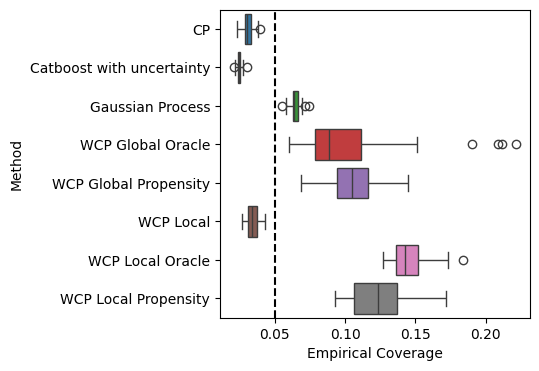

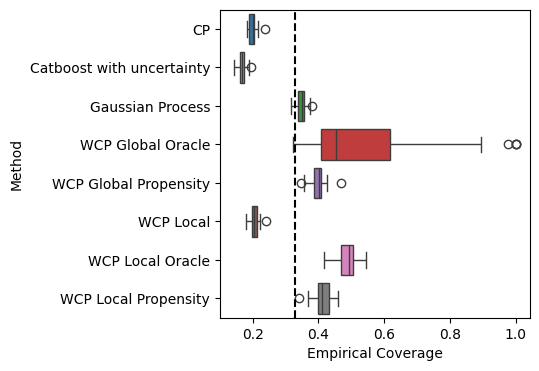

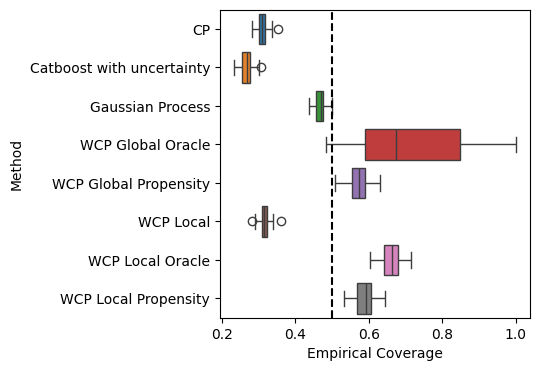

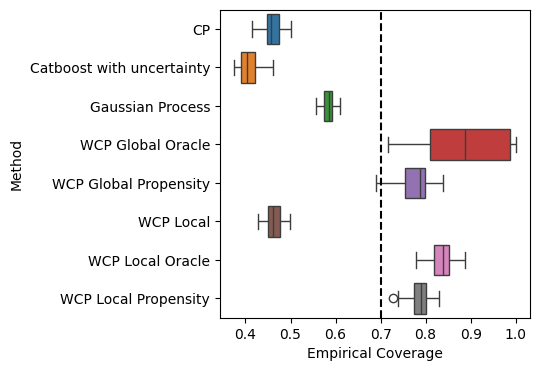

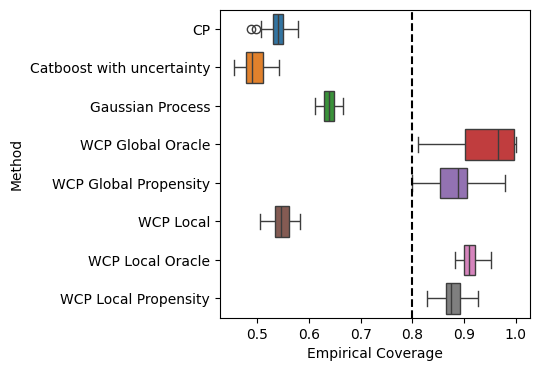

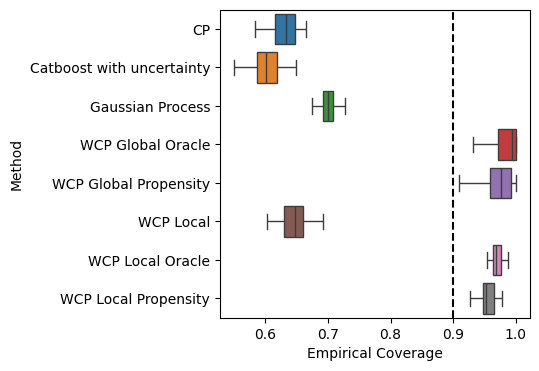

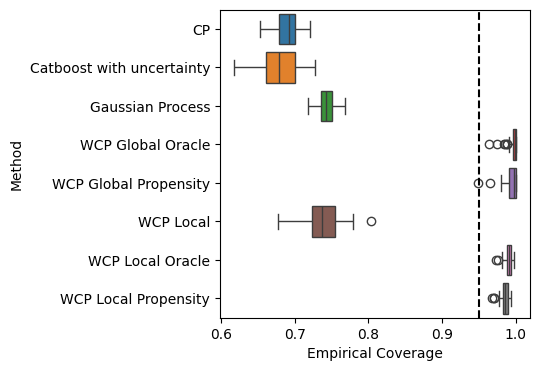

In [65]:
import seaborn as sns

for required_cov in cov_range:
    repeat_numb_test = all_results_df[(all_results_df.confidence == required_cov)&(all_results_df.repeat_numb.isin(np.arange(0,50,1)))][["repeat_numb","Method","Empirical Coverage"]].groupby(["Method","repeat_numb"]).mean().reset_index()

    fig, axs = plt.subplots(1, 1, figsize=(4,4))
    
    sns.boxplot(
        repeat_numb_test, x="Empirical Coverage", y="Method", hue="Method", ax=axs 
    )
    axs.axvline(x = required_cov, color="black", linestyle="--")
    # axs.set_title(f"cov = {required_cov}")

    fig.savefig("figures/coverage_barplot_cov_"+str(int(required_cov*100))+"_source_"+str(EXPERIMENT_SOURCE)+"_scenario_"+str(EXPERIMENT_SCENARIO)+".pdf",bbox_inches="tight")


    plt.show()

In [ ]:
import seaborn as sns

for plot_treatment in all_results_df["treatment"].unique():
    required_cov = 0.8
    repeat_numb_test = all_results_df[(all_results_df.treatment == plot_treatment)&(all_results_df.confidence == required_cov)&(all_results_df.repeat_numb.isin(np.arange(0,50,1)))][["repeat_numb","method","emp_coverage"]].groupby(["method","repeat_numb"]).mean().reset_index()

    fig, axs = plt.subplots(1, 1, figsize=(8,6))
    
    sns.boxplot(
        repeat_numb_test, x="emp_coverage", y="method", hue="method", ax=axs #width=.6, palette="vlag"
    )
    axs.axvline(x = required_cov, color="black", linestyle="--")
    axs.set_title(f"cov = {required_cov} | treatment = {plot_treatment}")

    plt.show()